In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.special import erf
import vegas, gvar

from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

from functools import partial

In [2]:
import math

In [3]:
import time
from collections import namedtuple
import vegasflow as vflow

In [4]:
from iflow import *

In [5]:
from my_iflow_test_short import *

In [6]:
ndims = 4
alpha = 0.2
calls = 0




In [7]:
vec = tf.constant([[1.0, 2.0], [3.0, 4.0]])
idx = [1, 0]

tf.gather(vec, idx, axis=1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 1.],
       [4., 3.]], dtype=float32)>

In [8]:
real = tf.constant([2.25, 3.25])
imag = tf.constant([4.75, 5.75])
tf.complex(real, imag)

<tf.Tensor: shape=(2,), dtype=complex64, numpy=array([2.25+4.75j, 3.25+5.75j], dtype=complex64)>

In [9]:
tf.math.real(tf.complex(real, imag))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.25, 3.25], dtype=float32)>

In [10]:
tf.exp(tf.constant([[1.0, 2.0], [3.0, 4.0]]))[:, 1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 7.389056, 54.59815 ], dtype=float32)>

In [11]:
def E(r, t, b, params):
    """"""
    a = tf.constant(params['a'], dtype=tf.float64)
    d = tf.constant(params['d'], dtype=tf.float64)
    
    x = tf.reshape(r[:, 0], shape=(-1,1))
    y = tf.reshape(r[:, 1], shape=(-1,1))
    z = tf.reshape(r[:, 2], shape=(-1,1))
    
    #print(f'E - {x.shape} {y.shape} {z.shape} {t.shape}')
    
    real = - (a * b) ** 2 / 2 * (z - t) ** 2 - (d * b) ** 2 * (x ** 2 + y ** 2)
    imag = b * (z - t)
    
    to_exp = tf.complex(real, imag)
    
    #print(f'E - {real.shape} {imag.shape}')
    
    return tf.reshape(tf.exp(to_exp), shape=(r.shape[0],1))


# test
params = {'a': 0.1, 'd': 0.1}
r = tf.random.uniform([6, 3], dtype=tf.float64)
t = tf.constant(0, dtype=tf.float64)
b = tf.constant(0.2, dtype=tf.float64)

E(r, t, b, params)

<tf.Tensor: shape=(6, 1), dtype=complex128, numpy=
array([[0.99934845+0.02825586j],
       [0.99809248+0.05489203j],
       [0.9844104 +0.17482087j],
       [0.98484052+0.17004036j],
       [0.99955227+0.02422407j],
       [0.9950855 +0.09776343j]])>

In [12]:
def C(r, t, n):
    """"""
    real = tf.constant(0, dtype=tf.float64)
    imag = t - tf.tensordot(r, n, axes=1)
    
    #print(f'C - {t.shape} {tf.tensordot(r, n, axes=1).shape}')
    #print(f'C - {real.shape} {imag.shape}')
    
    to_exp = tf.complex(real, imag)
        
    return tf.reshape(tf.exp(to_exp), shape=(r.shape[0],1))


# test
r = tf.random.uniform([6, 3], dtype=tf.float64, seed=0)
t = tf.constant(0, dtype=tf.float64)
n = tf.constant([1, 0, 0], shape=(3,1), dtype=tf.float64)

C(r, t, n)

<tf.Tensor: shape=(6, 1), dtype=complex128, numpy=
array([[0.69173947-0.72214715j],
       [0.72776093-0.6858309j ],
       [0.99973127-0.02318152j],
       [0.98140897-0.19192818j],
       [0.93511111-0.35435464j],
       [0.60437188-0.79670235j]])>

In [13]:
def J(r, t, b, n, params):
    """"""
    b_1 = tf.constant(params['b_1'], dtype=tf.float64)
    b_2 = tf.constant(params['b_2'], dtype=tf.float64)
    b_3 = tf.constant(params['b_3'], dtype=tf.float64)
    
    rz = tf.gather(r, [0, 1, 2], axis=1)
    ry = tf.gather(r, [2, 0, 1], axis=1)
    rx = tf.gather(r, [1, 2, 0], axis=1)
    
    #print('J -', rz.shape, t.shape, n.shape)
    
    j = C(rz, t, n)
    #print(f'J - C - {j.shape}')
    
    j *= E(rz, t, b_1, params)
    #print(f'J - CE - {j.shape}')
    
    j *= E(ry, t, b_2, params)
    #print(f'J - CEE - {j.shape}')
    
    j *= E(rx, t, b_3, params)
    #print(f'J - CEEE - {j.shape}')
    
    return j


# test
params = {'a': 0.1, 'd': 0.1, 'b_1': 0.2, 'b_2': 0.2, 'b_3': 0.2}
r = tf.random.uniform([6, 3], dtype=tf.float64, seed=0)
t = tf.constant(0, dtype=tf.float64)
b = tf.constant(0.2, dtype=tf.float64)
n = tf.constant([1, 0, 0], shape=(3,1), dtype=tf.float64)

J(r, t, b, n, params)

<tf.Tensor: shape=(6, 1), dtype=complex128, numpy=
array([[0.95204365+0.30092343j],
       [0.99476474-0.10085064j],
       [0.97671029+0.20878377j],
       [0.94433552-0.32438485j],
       [0.98086575+0.1884891j ],
       [0.85108772-0.52257082j]])>

In [14]:
# def gauss(x, **kwargs):
#     """"""
#     pre = tf.cast(1.0/(testfun_params['alpha'] * tf.sqrt(np.pi))**testfun_params['ndims'],
#                   dtype=tf.float64)
#     exponent = -1.0*tf.reduce_sum(((x-0.5)**2)/testfun_params['alpha']**2, axis=-1)
#     testfun_params['calls'] += 1
#     return pre * tf.exp(exponent)


@tf.function
def j_integrand(x: '(r,t)', b, n, params, **kwargs):
    """j(r, t, b, n) + params={b_1, b_2, b_3, a, d}"""
    r = x[:, :3]
    t = tf.reshape(x[:, -1], shape=(-1,1))
    
    #print('j_integrand() -' , r.shape, t.shape)
        
    res = tf.math.real(J(r, t, b, n, params))
    res = tf.reshape(res, shape=(-1,))
    res = tf.clip_by_value(res, clip_value_min=-5000, clip_value_max=5000)
    
    return res



# test
params = {'a': 0.1, 'd': 0.1, 'b_1': 0.2, 'b_2': 0.2, 'b_3': 0.2}
r = tf.random.uniform([6, 3], dtype=tf.float64, seed=0)
t = tf.constant(0, shape=(r.shape[0], 1), dtype=tf.float64)
b = tf.constant(0.2, dtype=tf.float64)
n = tf.constant([1, 0, 0], shape=(3,1), dtype=tf.float64)

x = tf.concat([r, t], axis=1)
j_integrand(x, b, n, params)

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.96545682, 0.99879322, 0.99854965, 0.99998804, 0.81157791,
       0.9506555 ])>

In [15]:
@tf.function
def analytic_solution(b, n, params, **kwargs):
    """params={a, d}"""
       
    a = tf.constant(params['a'], dtype=tf.float64)
    d = tf.constant(params['d'], dtype=tf.float64)
    pi = tf.constant(math.pi, dtype=tf.float64)
    
    a2 = a ** 2
    b2 = b ** 2
    d2 = d ** 2
    
    a4 = a2 ** 2
    b4 = b2 ** 2
    d4 = d2 ** 2
    
    eps = tf.constant(1e-8, dtype=tf.float64)
    
    c = 2 * pi ** 2 / (3 ** .5 * a  * b4 * d * (a2 + 4 * d2))
    
    nx = n[0]
    ny = n[1]
    nz = n[2]
    
    exp_numer = 16 * (1 - 3 * b) ** 2 * d4
    exp_numer += 4 * a2 * d2 * (9 * b2 - 6 * b - 2 * (nx + nx + nz) + 5)
    exp_numer += a4 * (nx + ny + nz - 1) ** 2
    
    exp_denom = 24 * a2 * b2 * d2 * (a2 + 4 * d2) + eps
    
    exp = tf.exp(- exp_numer / exp_denom)
    
    return c * exp


# test
params = {'a': 0.1, 'd': 0.1}
b = tf.constant(0.25, dtype=tf.float64)
n = tf.constant([1, 0, 0], shape=(3,1), dtype=tf.float64)

analytic_solution(b, n, params)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.34469569])>

### i-flow integrate

In [16]:
# test
params = {'a': 0.1, 'd': 0.1, 'b_1': 0.25, 'b_2': 0.25, 'b_3': 0.25}
r = tf.random.uniform([6, 3], dtype=tf.float64, seed=0)
t = tf.constant(0, shape=(r.shape[0], 1), dtype=tf.float64)
b = tf.constant(0.25, dtype=tf.float64)
n = tf.constant([1, 0, 0], shape=(3,1), dtype=tf.float64)

x = tf.concat([r, t], axis=1)

# j_integrand(x, b, n, params)

In [17]:
ndims = 2
calls = 0

function = 'Custom'

testfun_params = {
    'ndims': ndims,
    'calls': 0,
}
testfun_params.update(params)

target = analytic_solution(b, n, params).numpy()[0]
print(target)

integrand = partial(j_integrand, b=b, n=n, params=testfun_params)
integrand(tf.random.uniform(shape=(10,ndims), minval=-10, maxval=10, dtype=tf.float64))

0.3446956853430457


<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.03697499,  0.18620336,  0.79719112, -0.11024124, -0.35732661,
        0.73413262,  0.72792371,  0.60429412,  0.96456737,  0.78905608])>

In [81]:
@tf.function
def integrand(x):
    return j_integrand(x, b=b, n=n, params=testfun_params)

### Crude MC

In [162]:
%%time

npts = 10000000
# pts = np.array(np.random.uniform(low=0, high=3, size=(npts, ndims)), dtype=np.float64)
pts = tf.random.uniform(
    shape=(npts, ndims),
    minval=-10,
    maxval=10,
    dtype=tf.float64,
#     seed=77,
)
value = integrand(pts)

format_string = ('Crude MC of {} function in {:d} dimensions based on '
                 '{:d} points: {:.3e} +/- {:.3e}')
print(format_string.format(function, ndims, npts,
                           tf.math.reduce_mean(value).numpy(),
                           tf.math.reduce_std(value).numpy() / np.sqrt(npts)))


epochs = 1000
ptspepoch = 5000
target_precision = 1e-4 * target

target_precision

Crude MC of Custom function in 2 dimensions based on 10000000 points: -1.712e-02 +/- 2.003e-04
Wall time: 165 ms


3.446956853430457e-05

In [19]:
from tqdm.notebook import tqdm

In [20]:
# temp_min = []
# temp_max = []

# for i in tqdm(range(100)):
    
#     npts = 1000000
#     pts = tf.random.uniform(
#         shape=(npts, ndims),
#         minval=-10,
#         maxval=10,
#         dtype=tf.float64,
#     )
    
#     value = integrand(pts)

#     temp_min.append(tf.math.reduce_min(value).numpy())
#     temp_max.append(tf.math.reduce_max(value).numpy())
    
    
# print(np.min(temp_min), np.max(temp_max))

  0%|          | 0/100 [00:00<?, ?it/s]

-0.9772872267121147 0.9999999977819996


### tensorflow

In [62]:
import vegasflow as vflow

In [113]:
n_dim = ndims
n_events = int(1e6)
events_limit = int(1e7)

In [126]:
vegas_integ = None

import gc
gc.collect()

21

In [127]:
vegas_integ = vflow.VegasFlow(n_dim=ndims, n_events=n_events, events_limit=events_limit, verbose=False, signature=True)
vegas_integ.compile(integrand)

In [166]:
from collections import namedtuple
result_tuple = namedtuple('result_tuple', ['mean', 'sdev'])

vegas_calls = []
vegas_results = []
vegas_means = []
vegas_stddevs = []

epoch = 0
current_vegas_precision = 1e99
while current_vegas_precision > target_precision:
    #current_result = vegas_integ(integrand_np, nitn=1, neval=ptspepoch)
    current_result = vegas_integ.run_integration(n_iter=1)
    current_result = result_tuple(*current_result)

    vegas_means.append(current_result.mean)
    vegas_stddevs.append(current_result.sdev)
    vegas_results.append(current_result)

    _, current_vegas_precision = variance_weighted_result(np.array(vegas_means),
                                                          np.array(vegas_stddevs))
    if True or epoch % 1 == 0:
        print('[VegasFlow] Epoch: {:3d} Integral = '
              '{:8e} +/- {:8e} Total uncertainty = {:8e} (>) {:8e}'.format(epoch, current_result.mean,
                                                                 current_result.sdev,
                                                                 current_vegas_precision, target_precision))
    epoch += 1
#     if np.sum(vegas_calls) > 50000000:
#         break

[VegasFlow] Epoch:   0 Integral = 9.580520e-01 +/- 3.142207e-05 Total uncertainty = 3.142207e-05 (>) 3.446957e-05


### i-flow

In [52]:
def build_iflow(func, ndims, low, high):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    bijector = []
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                             num_bins=16,
                                                             blob=None,
                                                             options=None))
    bijector = tfb.Chain(list(reversed(bijector)))
    # low = np.zeros(ndims, dtype=np.float64)
    # high = np.ones(ndims, dtype=np.float64)
    low = np.repeat(low, ndims).astype(np.float64)
    high = np.repeat(high, ndims).astype(np.float64)
    dist = tfd.Uniform(low=low, high=high, allow_nan_stats=False)
    dist = tfd.Independent(distribution=dist,
                           reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    integrate = integrator.Integrator(
        func, dist, optimizer,
#         loss_func='exponential',
        loss_func='kl'
    )

    return integrate

In [53]:
integrate = None

import gc
gc.collect()

3088

In [59]:
integrate.dist.sample(10)

<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]])>

In [60]:
integrate.dist.log_prob(tf.constant([1, 10, 100, 1000,10000], shape=(5,1), dtype=tf.float64))

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([nan, nan, nan, nan, nan])>

In [58]:
def train_iflow_target(integrate, ptspepoch, target):
    """ Run the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        target (float): target precision of final integral

    Returns:
        numpy.ndarray(float): integral estimations and its uncertainty of each epoch

    """
    means = []
    stddevs = []
    current_precision = 1e99
    epoch = 0
    while current_precision > target:
        loss, integral, error = integrate.train_one_step(ptspepoch, integral=True)
        means.append(integral)
        stddevs.append(error)
        
        _, current_precision = variance_weighted_result(np.array(means), np.array(stddevs))

        ###
        loss = loss.numpy()
        integral = integral.numpy()
        error = error.numpy()
        ###
        
#         print(epoch, loss, integral, error, current_precision)

        if epoch % 10 == 0:
            print('[i-flow] Epoch: {:3d} Loss = {:8e} Integral = '
                  '{:8e} +/- {:8e} Total uncertainty = {:8e}'
                  .format(epoch, loss, integral, error, current_precision))
        epoch += 1
    return np.array(means), np.array(stddevs)


# test
integrate = build_iflow(integrand, ndims, low=-10, high=10)
train_iflow_target(integrate, ptspepoch, target_precision)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 49)                1617      
Total params: 4,849
Trainable params: 4,849
Non-trainable params: 0
_________________________________________________________

(array([227.94922429, 293.52419463, 323.6086744 , 340.88155428,
        355.34634511, 365.56474549, 379.05833568, 391.24936516,
        400.4316425 , 408.68945363, 415.37104064, 419.46359427,
        424.62570154, 428.8699742 , 433.52858888, 431.83626689,
        432.49801398, 432.90871294, 431.60367043, 431.83233002,
        430.10614435, 427.514256  , 428.27871427, 425.30943237,
        421.33936647, 421.79610257, 420.86016979, 418.60551218,
        412.9091493 , 414.09676846, 416.28523109, 415.31682255,
        415.2571771 , 413.64167795, 414.17536158, 414.69216016,
        417.86686135, 415.73639721, 413.84012401, 416.51380824,
        413.50237523, 418.07776833, 421.12293568, 426.91544221,
        426.47494265, 427.49260096, 428.17111741, 426.02925347,
        426.932745  , 428.46800975, 423.38925047, 417.37030649,
        421.49406786, 424.2193515 , 425.05699183, 427.69747139,
        430.20688089, 430.32658683, 431.02348535, 431.35399174,
        432.64637468, 430.77046717, 426.

In [24]:
# integrate.train_one_step(ptspepoch, integral=True)

In [25]:
params_dict = {}
params_dict['i_flow'] = {}


print('\n')

print('[i-flow] BUILD\n')
start = time.time()
integrate = build_iflow(integrand, ndims, low=-10, high=10)
end = time.time()
print(f"[i-flow] BUILD time: {(end-start):.4f} s\n")

params_dict['i_flow']['build_time'] = end - start



[i-flow] BUILD

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 49)                1617      
Total params: 4,849
Trainable params: 4,849
Non-trainable params: 0
_______________________________________

In [26]:
print('[i-flow] START\n')
start = time.time()
mean_t, err_t = train_iflow_target(integrate, ptspepoch, target_precision)
end = time.time()
print(f"[i-flow] END time: {int(end-start)} s\n")

params_dict['i_flow']['run_time'] = end - start

num_epochs = len(mean_t)
x_values = np.arange(ptspepoch, (num_epochs+1) * ptspepoch, ptspepoch)
iflow_mean_wgt, iflow_err_wgt = variance_weighted_result(mean_t, err_t)

print("[i-flow] Results for {:d} dimensions:\n".format(ndims))
print("[i-flow] Weighted iflow result is {:.5e} +/- {:.5e}.\n".format(
    iflow_mean_wgt, iflow_err_wgt))
print("[i-flow] Relative Uncertainty iflow result is {:.3f}\n".format(
    rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.)))
print("[i-flow] i-flow needed {:d} epochs and {:d} function calls\n".format(
    num_epochs,
    num_epochs*ptspepoch
))

params_dict['i_flow']['w_mean'] = float(iflow_mean_wgt)
params_dict['i_flow']['w_err'] = float(iflow_err_wgt)
params_dict['i_flow']['rel_unc'] = float(rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.))
params_dict['i_flow']['res_epochs'] = num_epochs
params_dict['i_flow']['res_calls'] = num_epochs * ptspepoch

[i-flow] START

(5000,) (5000,) (5000,) (5000,)
(5000,) (5000,) (5000,) (5000,)
[i-flow] Epoch:   0 Loss = 1.482576e-01 Integral = 2.274504e+02 +/- 1.579470e+00 Total uncertainty = 1.579470e+00
[i-flow] Epoch:  10 Loss = 4.904286e-02 Integral = 4.207071e+02 +/- 1.669551e+00 Total uncertainty = 4.868081e-01
[i-flow] Epoch:  20 Loss = 4.021437e-02 Integral = 4.194795e+02 +/- 1.486702e+00 Total uncertainty = 3.480318e-01
[i-flow] Epoch:  30 Loss = 3.520691e-02 Integral = 3.926697e+02 +/- 1.270078e+00 Total uncertainty = 2.676398e-01
[i-flow] Epoch:  40 Loss = 3.523485e-02 Integral = 3.913282e+02 +/- 1.277046e+00 Total uncertainty = 2.223108e-01
[i-flow] Epoch:  50 Loss = 3.369508e-02 Integral = 3.922016e+02 +/- 1.255163e+00 Total uncertainty = 1.948304e-01
[i-flow] Epoch:  60 Loss = 2.781082e-02 Integral = 3.904077e+02 +/- 1.140870e+00 Total uncertainty = 1.743145e-01
[i-flow] Epoch:  70 Loss = 3.051479e-02 Integral = 3.835051e+02 +/- 1.172740e+00 Total uncertainty = 1.582839e-01
[i-flow]

In [27]:
params_dict

{'i_flow': {'build_time': 0.11868119239807129,
  'run_time': 5.336259126663208,
  'w_mean': nan,
  'w_err': nan,
  'rel_unc': nan,
  'res_epochs': 179,
  'res_calls': 895000}}

In [28]:
data = integrate.sample(500).numpy()

E:\_MAGISTER_ACE\Наука\test-env\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
E:\_MAGISTER_ACE\Наука\test-env\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

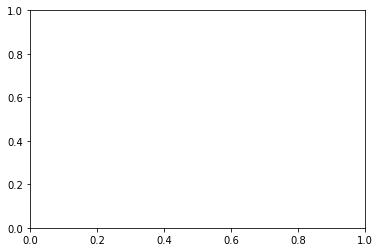

In [29]:
plt.hist(data);